In [3]:
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
def per_step_displacements(df_corrected: pd.DataFrame, dt: int = 1) -> pd.DataFrame:
    """
    Compute consecutive-step displacements for each track id.
    Returns one row per valid step (from timestep t to t+dt).
    Columns:
      id, t_start, t_end, dx, dy, step, step2, area_start, area_end, area_mean
    """
    cols_needed = {"id", "timestep", "x", "y"}
    if not cols_needed.issubset(df_corrected.columns):
        raise ValueError(f"DataFrame must contain {cols_needed}")

    g = df_corrected.sort_values(["id", "timestep"]).copy()

    # Shift within each id
    g["x_next"] = g.groupby("id")["x"].shift(-dt)
    g["y_next"] = g.groupby("id")["y"].shift(-dt)
    g["t_next"] = g.groupby("id")["timestep"].shift(-dt)
    
    # Displacements
    g["dx"] = g["x_next"] - g["x"]
    g["dy"] = g["y_next"] - g["y"]
    g["step2"] = g["dx"]**2 + g["dy"]**2
    g["step"]  = np.sqrt(g["step2"])
    
    # Coarsening proxy via area (optional)
    if "area" in g.columns:
        g["area_start"] = g["area"]
        g["area_end"]   = g.groupby("id")["area"].shift(-dt)
        g["area_mean"]  = (g["area_start"] + g["area_end"]) / 2.0
    else:
        g["area_start"] = np.nan
        g["area_end"]   = np.nan
        g["area_mean"]  = np.nan
    
    out = g.dropna(subset=["x_next", "y_next", "t_next"]).copy()
    out = out.rename(columns={"timestep":"t_start", "t_next":"t_end"})
    return out[["id","t_start","t_end","dx","dy","step","step2","area_start","area_end","area_mean"]]

steps = per_step_displacements(df_corrected, dt=1)
steps.head()
print(steps)

        id  t_start  t_end        dx        dy      step         step2  \
0        1        0    1.0  0.000228 -0.002616  0.002626  6.895440e-06   
400      1        1    2.0  0.000918 -0.007069  0.007128  5.081349e-05   
800      1        2    3.0  0.001747 -0.013437  0.013550  1.836050e-04   
1200     1        3    4.0  0.002239 -0.013881  0.014060  1.976953e-04   
1600     1        4    5.0  0.001241 -0.002907  0.003161  9.990730e-06   
...    ...      ...    ...       ...       ...       ...           ...   
14497  400       37   38.0 -0.049854  0.002759  0.049930  2.493033e-03   
14852  400       38   39.0 -0.000457 -0.000049  0.000460  2.112500e-07   
15205  400       39   40.0  0.001561 -0.001090  0.001904  3.624821e-06   
15555  400       40   41.0  0.004608 -0.000897  0.004694  2.203827e-05   
15903  400       41   42.0  0.002180 -0.000086  0.002182  4.759796e-06   

       area_start  area_end  area_mean  
0        1.505199  1.508457   1.506828  
400      1.508457  1.511703  

In [5]:
summary_by_time = (
    steps.groupby("t_start")
         .agg(n=("step2","size"),
              mean_step2=("step2","mean"),
              median_step2=("step2","median"),
              std_step2=("step2","std"),
              mean_step=("step","mean"),
              median_step=("step","median"))
         .reset_index()
) # Compute summary statistics per timestep

# Standard error for the mean (useful error bars)
summary_by_time["sem_step2"] = summary_by_time["std_step2"] / np.sqrt(summary_by_time["n"])
summary_by_time.head()

,t_start,n,mean_step2,median_step2,std_step2,mean_step,median_step,sem_step2
0,0,400,0.000036,0.000012,0.000090,0.004485,0.003465,0.000004
1,1,400,0.000030,0.000011,0.000076,0.004115,0.003252,0.000004
2,2,400,0.000062,0.000015,0.000208,0.005407,0.003935,0.000010
3,3,400,0.000059,0.000017,0.000166,0.005462,0.004108,0.000008
4,4,400,0.000021,0.000005,0.000127,0.002939,0.002266,0.000006


0.5063452675


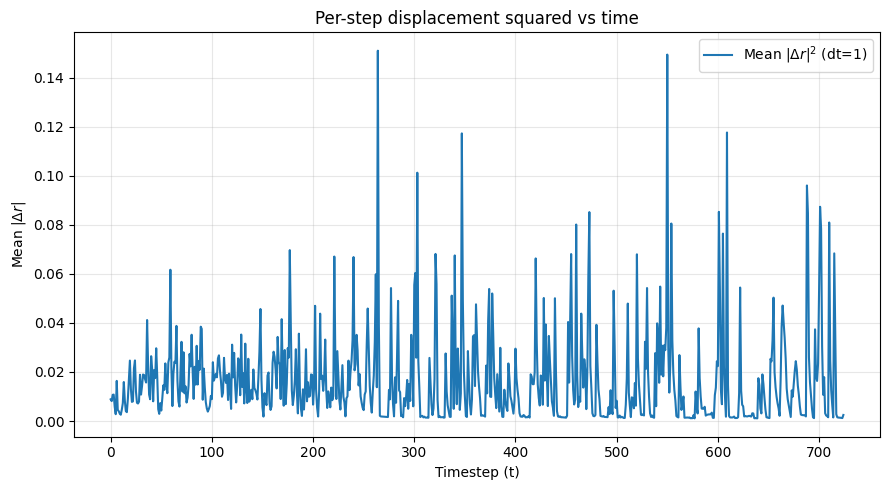

Got 400 bubbles' first steps
[0.00262592 0.00333269 0.00153103 0.00394682 0.00371523 0.00247823
 0.00262571 0.00181256 0.00253863 0.00449307 0.00944503 0.00274573
 0.00027308 0.00226862 0.00188206 0.00474764 0.00401538 0.00320429
 0.00450907 0.0050246  0.00248624 0.00435282 0.00458431 0.00747546
 0.00578716 0.01508793 0.00503371 0.00329987 0.00486722 0.00996817
 0.00437893 0.01933584 0.00273904 0.00110768 0.00111494 0.00119014
 0.0032481  0.00071603 0.00450557 0.0028712  0.00283291 0.00194404
 0.00766625 0.00022874 0.00124486 0.00286734 0.00275798 0.00118287
 0.01256746 0.00516295 0.00246411 0.00109229 0.00254264 0.00186583
 0.00226427 0.00522422 0.0013446  0.00254276 0.00353936 0.00123024
 0.00448201 0.00671052 0.00162607 0.00365993 0.00381536 0.00265181
 0.00954488 0.00210977 0.00813031 0.00659503 0.00437129 0.00091994
 0.00468392 0.00430941 0.00859861 0.00509389 0.00296924 0.00448798
 0.00787836 0.00503891 0.00531707 0.00364416 0.00491912 0.00183858
 0.01067492 0.00165375 0.00061805

In [6]:
# divide by the initial bubble diameter
initial_averagediam = df_corrected[df_corrected["timestep"]==0]["area"].mean()
print(initial_averagediam)

# Plot mean per-step squared displacement vs time
plt.figure(figsize=(9,5))
plt.plot(summary_by_time["t_start"], (summary_by_time["mean_step"]/(initial_averagediam)), label=r"Mean $|\Delta r|^2$ (dt=1)")
plt.xlabel("Timestep (t)")
plt.ylabel(r"Mean $|\Delta r|$")
plt.title("Per-step displacement squared vs time")
plt.legend()
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

# print out 400 values of first step
first_steps = steps[steps["t_start"] == 0]["step"].values
print(f"Got {len(first_steps)} bubbles' first steps")
print(first_steps)



0.5063452675
[0.00518602 0.00658186 0.00302369 0.00779472 0.00733734 0.00489435
 0.00518561 0.00357969 0.00501364 0.00887353 0.01865334 0.00542264
 0.00053931 0.00448039 0.00371695 0.0093763  0.00793012 0.00632826
 0.00890512 0.00992327 0.00491017 0.00859655 0.00905372 0.01476356
 0.01142927 0.02979771 0.00994127 0.00651704 0.00961246 0.01968651
 0.00864811 0.03818707 0.00540943 0.0021876  0.00220194 0.00235046
 0.0064148  0.00141412 0.00889823 0.00567044 0.00559482 0.00383935
 0.01514037 0.00045175 0.00245852 0.00566281 0.00544683 0.00233609
 0.02481994 0.01019651 0.00486645 0.0021572  0.00502155 0.0036849
 0.0044718  0.0103175  0.00265549 0.0050218  0.00699002 0.00242964
 0.00885168 0.01325286 0.00321138 0.00722812 0.0075351  0.00523716
 0.01885055 0.00416666 0.01605686 0.01302476 0.00863303 0.00181682
 0.00925045 0.00851082 0.01698171 0.01006011 0.00586407 0.00886348
 0.01555927 0.00995154 0.01050087 0.00719699 0.00971495 0.00363107
 0.02108229 0.00326605 0.00122061 0.01130421 0.004

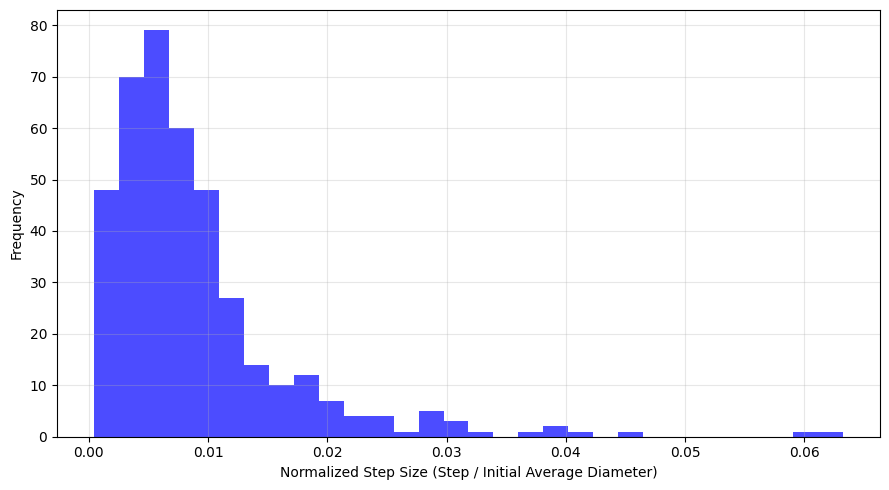

In [7]:

# divide by the initial bubble diameter
initial_averagediam = df_corrected[df_corrected["timestep"]==0]["area"].mean()
print(initial_averagediam)

#divide first 400 steps by initial average diameter
normalized_steps = first_steps / initial_averagediam
print(normalized_steps)

# create a histogram of the normalized steps
plt.figure(figsize=(9,5))
plt.hist(normalized_steps, bins=30, alpha=0.7, color='blue')
plt.xlabel("Normalized Step Size (Step / Initial Average Diameter)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Plotting 8 timesteps: [0, 100, 200, 300, 400, 500, 600, 700]
Creating 3x3 grid


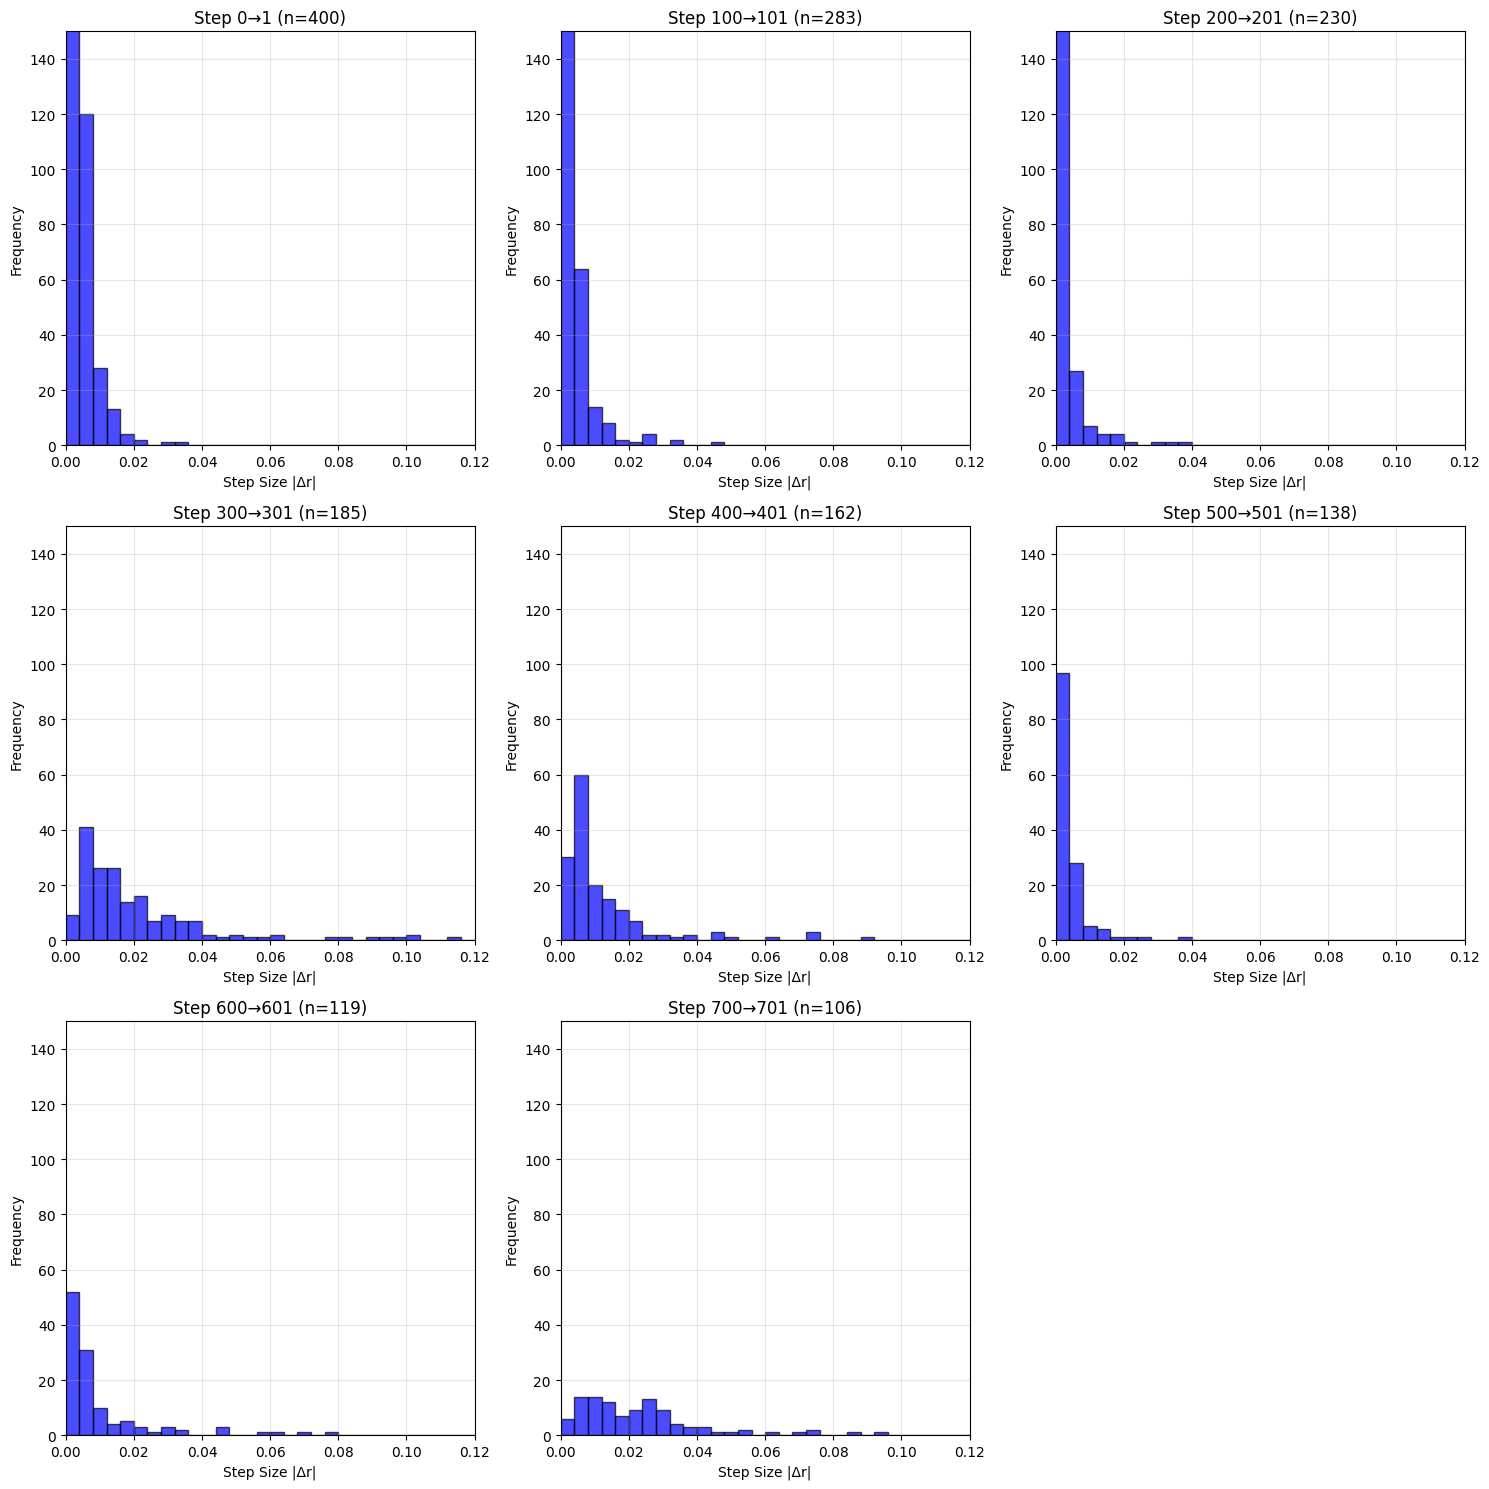

In [8]:
# Get steps at regular intervals (every 100th step)
max_timestep = steps["t_start"].max()
step_interval = 100
timesteps_to_plot = list(range(0, max_timestep + 1, step_interval))

print(f"Plotting {len(timesteps_to_plot)} timesteps: {timesteps_to_plot}")

# Calculate grid size dynamically
n_plots = len(timesteps_to_plot)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

print(f"Creating {n_rows}x{n_cols} grid")

# Plot histograms
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.ravel()

for idx, t in enumerate(timesteps_to_plot):
    step_data = steps[steps["t_start"] == t]["step"].values
    
    if len(step_data) > 0:
        # Use range=(0, 0.12) to force consistent bin edges
        axes[idx].hist(step_data, bins=30, range=(0, 0.12), 
                      alpha=0.7, color='blue', edgecolor='black')
        axes[idx].set_title(f"Step {t}→{t+1} (n={len(step_data)})")
        axes[idx].set_xlabel("Step Size |Δr|")
        axes[idx].set_ylabel("Frequency")
        axes[idx].grid(alpha=0.3)
        axes[idx].set_xlim(0, 0.12)
        axes[idx].set_ylim(0, 150)
    else:
        axes[idx].text(0.5, 0.5, f'No data at t={t}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"Step {t}→{t+1}")

# Remove empty subplots if any
for idx in range(n_plots, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

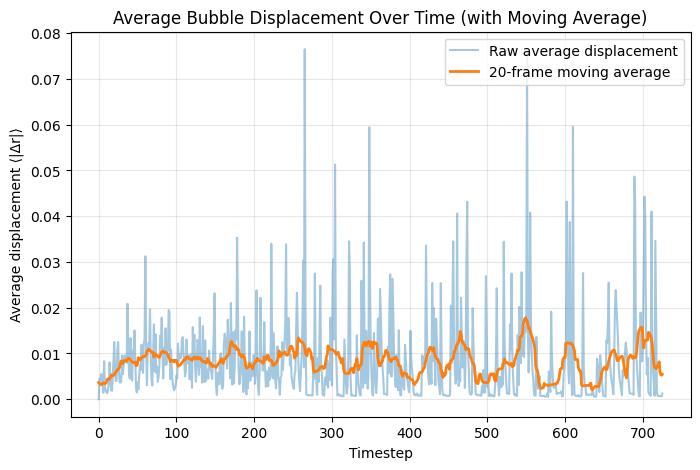

In [9]:

# Sort for safety
df_corrected = df_corrected.sort_values(["id", "timestep"])

# Compute per-bubble step displacement
df_corrected["disp_mag"] = (
    df_corrected.groupby("id")[["x", "y"]]
    .diff()
    .pow(2)
    .sum(axis=1)
    .pow(0.5)
)

avg_disp_per_timestep = (
    df_corrected.groupby("timestep")["disp_mag"]
    .mean()
    .reset_index(name="avg_disp")
)

window = 20

avg_disp_per_timestep["avg_disp_smooth"] = (
    avg_disp_per_timestep["avg_disp"]
    .rolling(window=window, min_periods=1, center=True)
    .mean()
)


plt.figure(figsize=(8, 5))
plt.plot(avg_disp_per_timestep["timestep"], avg_disp_per_timestep["avg_disp"], label="Raw average displacement", alpha=0.4)
plt.plot(avg_disp_per_timestep["timestep"], avg_disp_per_timestep["avg_disp_smooth"], label=f"{window}-frame moving average", linewidth=2)
plt.xlabel("Timestep")
plt.ylabel("Average displacement ⟨|Δr|⟩")
plt.title("Average Bubble Displacement Over Time (with Moving Average)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()